![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Final Project: Contextual Bandits - Algorithm Analysis*

## Reinforcement Learning

#### Authors: **Timothy Cassel, Marvin Ernst, Oliver Tausendschön**

Date: July 2, 2025  
Instructors: *Hamish Flynn and Vincent Adam*

---

### **06 Off-Policy Evaluation with Preprocessed Top-3 Arms and Full Dataset**

In this notebook, we extend our contextual bandit analysis using the **Open Bandit Dataset (OBD)**. The focus lies on evaluating multiple offline estimators across different policies using a reduced dataset (top-3 arms) and the full dataset (80 arms).

We perform the following:
- Correct for uniform **propensity scores** in subset data (1/3 for 3 arms)
- Define and simulate the following policies:
  - **Random**
  - **Thompson Sampling (TS)**
  - **LinUCB** variants ($\alpha$ = 0.0, 0.1, 0.5)
  - **LinEpsilonGreedy ($\epsilon$ = 0.1)**
- Train a **reward model** using **Logistic Regression** for use in model-based OPE estimators
- Evaluate all policies using:
  - **Inverse Propensity Weighting (IPW)**
  - **Direct Method (DM)**
  - **Doubly Robust (DR)**
- Visualize estimated policy values with **confidence intervals**
- Compare findings between the reduced and full dataset

The notebook provides insight into how offline estimators behave under different data regimes and how policies compare in terms of performance and estimator reliability.

---

Import relevant Libraries:

In [1]:
import numpy as np
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from obp.policy import BernoulliTS, LinUCB, LinEpsilonGreedy
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
)

/Users/Admin/Documents/Git/BSE/RL/contextual-bandit-benchmark/obp-py39-env/lib/python3.9/site-packages/torch/torch_version.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
/Users/Admin/Documents/Git/BSE/RL/contextual-bandit-benchmark/obp-py39-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Important to use correct propensity Scores!**

Since we only use a fraction of the real data set, i.e., only 3 arms, the need to change.

Loading the propnsity score:

In [77]:
pscore=np.load("processed_top3/pscores.npy")

Checking Propensity Scores:

In [78]:
print("Min pscore:", pscore.min())
print("Max pscore:", pscore.max())
print("Mean pscore:", pscore.mean())
print("Share of pscores < 0.01:", (pscore < 0.01).mean())

Min pscore: 0.0125
Max pscore: 0.0125
Mean pscore: 0.012500000000000002
Share of pscores < 0.01: 0.0


This confirms, they are all the same, i.e., 1/80 = 0.0125 - since we have 80 arms and they are chosen randomly.

Thus, we need to correct them to 1/3!

### 1. Load Preprocessed Data
We create a dictionary `bandit_feedback` with:
- context
- action
- reward
- pscore (first with placeholder)
- position (if list-wise, else fill with 0s)

In [79]:
bandit_feedback = dict(
    n_actions=3,
    context=np.load("processed_top3/context_reduced.npy"),
    action=np.load("processed_top3/actions.npy"),
    reward=np.load("processed_top3/rewards.npy"),
    pscore=None  
)

Now, we replace with correct uniform propensity scores:

In [80]:
bandit_feedback["pscore"] = np.full_like(bandit_feedback["action"], fill_value=1/3, dtype=np.float64)

We add a dummy position info:

In [81]:
bandit_feedback["position"] = np.zeros_like(bandit_feedback["action"])

Sanity check:

In [100]:
print("Context shape:", bandit_feedback["context"].shape)
print("Min pscore:", bandit_feedback["pscore"].min())
print("Max pscore:", bandit_feedback["pscore"].max())
print("Mean pscore:", bandit_feedback["pscore"].mean())

Context shape: (1374327, 12)
Min pscore: 0.0125
Max pscore: 0.0125
Mean pscore: 0.012499999999999976


### 2. Define Evaluation Policies

In [ ]:
n_rounds = len(bandit_feedback["action"])
n_actions = int(np.max(bandit_feedback["action"]) + 1)
dim_context = bandit_feedback["context"].shape[1]

policies = {
    "Random": None,  
    "TS": BernoulliTS(n_actions=n_actions, len_list=1, random_state=123),
    "LinUCB (\u03b1=0.0)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.0, random_state=1),
    "LinUCB (\u03b1=0.1)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.1, random_state=2),
    "LinUCB (\u03b1=0.5)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.5, random_state=3),
    "LinEG (\u03B5=0.1)": LinEpsilonGreedy(n_actions=n_actions, dim=dim_context, epsilon=0.1, random_state=4),
}

We compute action distributions:

In [84]:
action_dists = {}

for name, policy in policies.items():
    if name == "Random":
        action_dists[name] = np.ones((n_rounds, n_actions, 1)) / n_actions
    elif hasattr(policy, "compute_batch_action_dist"):
        action_dists[name] = policy.compute_batch_action_dist(n_rounds=n_rounds, n_sim=10000)
    else:
        # For LinUCB and LinEpsilonGreedy: simulate batch manually
        action_dist = np.full((n_rounds, n_actions, 1), policy.epsilon / n_actions)
        greedy_actions = np.zeros(n_rounds, dtype=int)
        for i in range(n_rounds):
            x_i = bandit_feedback["context"][i].reshape(1, -1)
            greedy_actions[i] = policy.select_action(context=x_i)
            action_dist[i, greedy_actions[i], 0] += 1.0 - policy.epsilon
        action_dists[name] = action_dist

### 3. Reward Model for DM and DR

In [85]:
regression_model = RegressionModel(
    n_actions=n_actions,
    len_list=1,
    base_model=LogisticRegression(max_iter=1000, random_state=123),
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3,
    random_state=123,
)

### 4. Off-Policy Evaluation

Set seaborn style:

In [86]:
sns.set(style="whitegrid", font_scale=1.2)

Define OPE estimators:

In [87]:
ope_estimators = [InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=ope_estimators,
)

We run OPE and store estimated policy values and CIs:

In [88]:
results = []

for policy_name in policies:
    if action_dists.get(policy_name) is None:
        continue

    est_value, ci = ope.summarize_off_policy_estimates(
        action_dist=action_dists[policy_name],
        estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
        n_bootstrap_samples=5000,
        random_state=42,
    )

    for estimator_name in est_value.index:
        value = est_value.loc[estimator_name, "estimated_policy_value"]
        lower = ci.loc[estimator_name, "95.0% CI (lower)"]
        upper = ci.loc[estimator_name, "95.0% CI (upper)"]

        results.append({
            "Policy": policy_name,
            "Estimator": estimator_name,
            "Estimated Value": value,
            "CI Lower": lower,
            "CI Upper": upper,
            "CI Width": upper - lower
        })

We create DataFrame:

In [89]:
df_results = pd.DataFrame(results)

#### **Relative Policy Values**

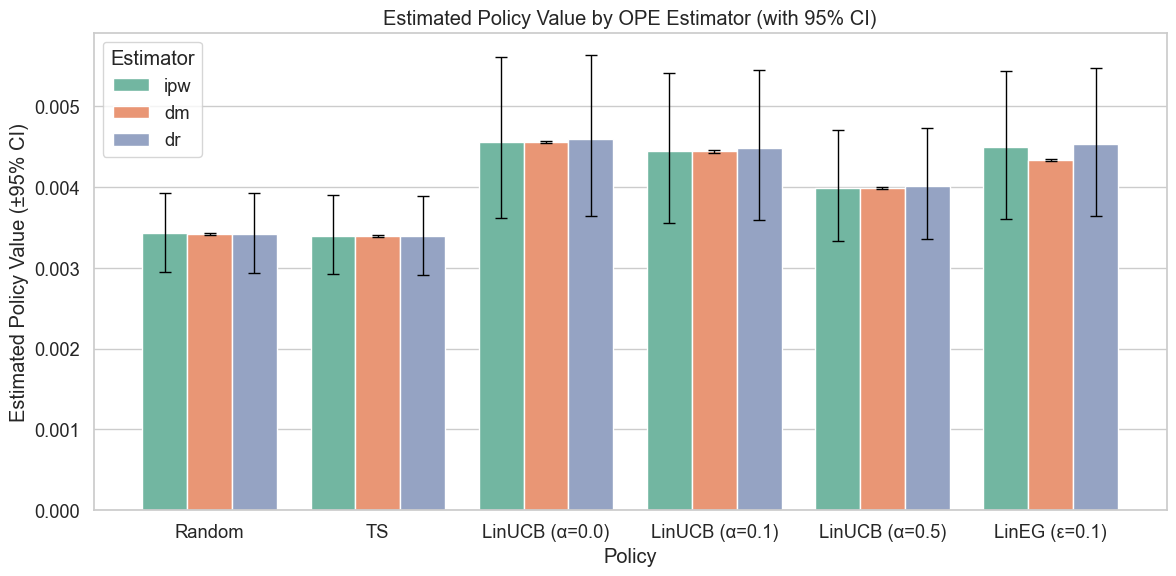

In [90]:
plt.figure(figsize=(12, 6))

# Main barplot
ax = sns.barplot(
    data=df_results,
    x="Policy",
    y="Estimated Value",
    hue="Estimator",
    palette="Set2",
    ci=None,
    dodge=True,
)

# Extract hue order to match estimator mapping:
hue_order = df_results["Estimator"].unique().tolist()
n_hue = len(hue_order)
bar_width = 0.8 / n_hue  # total bar width split across estimators

# Compute correct x-position and draw error bars manually:
for i, row in df_results.iterrows():
    policy_index = df_results["Policy"].unique().tolist().index(row["Policy"])
    estimator_index = hue_order.index(row["Estimator"])

    # Calculate x-position:
    x = policy_index - 0.4 + bar_width / 2 + estimator_index * bar_width
    y = row["Estimated Value"]
    err_low = y - row["CI Lower"]
    err_up = row["CI Upper"] - y

    # Adding error bar:
    ax.errorbar(
        x=x,
        y=y,
        yerr=[[err_low], [err_up]],
        fmt='none',
        c='black',
        capsize=4,
        lw=1,
    )

# Full plot:
plt.title("Estimated Policy Value by OPE Estimator (with 95% CI)")
plt.xticks(rotation=0, ha="center")
plt.ylabel("Estimated Policy Value (±95% CI)")
plt.tight_layout()
plt.legend(title="Estimator")
plt.show()

---

### **5. Evaluating the Full Data**

We still use the preprocessed data, but now, with all arms.

**Better to RESTART the Kernel!**

In [2]:
bandit_feedback = dict(
    n_actions=80,
    context=np.load("processed/context_reduced.npy"),
    action=np.load("processed/actions.npy"),
    reward=np.load("processed/rewards.npy"),
    pscore=np.load("processed/pscores.npy")
)
bandit_feedback["position"] = np.zeros_like(bandit_feedback["action"])
print("Context shape:", bandit_feedback["context"].shape)

Context shape: (1374327, 12)


### 6. Update Evaluation Policies

In [3]:
n_rounds = len(bandit_feedback["action"])
n_actions = int(np.max(bandit_feedback["action"]) + 1)
dim_context = bandit_feedback["context"].shape[1]

policies = {
    "Random": None,  
    "TS": BernoulliTS(n_actions=n_actions, len_list=1, random_state=123),
    "LinUCB (\u03b1=0.0)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.0, random_state=1),
    "LinUCB (\u03b1=0.1)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.1, random_state=2),
    "LinUCB (\u03b1=0.5)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.5, random_state=3),
    "LinEG (\u03B5=0.1)": LinEpsilonGreedy(n_actions=n_actions, dim=dim_context, epsilon=0.1, random_state=4),
}

We compute again the action distributions:

In [ ]:
action_dists = {}

for name, policy in policies.items():
    if name == "Random":
        action_dists[name] = np.ones((n_rounds, n_actions, 1)) / n_actions
    elif hasattr(policy, "compute_batch_action_dist"):
        action_dists[name] = policy.compute_batch_action_dist(n_rounds=n_rounds, n_sim=10000)
    else:
        action_dist = np.full((n_rounds, n_actions, 1), policy.epsilon / n_actions)
        greedy_actions = np.zeros(n_rounds, dtype=int)
        for i in range(n_rounds):
            x_i = bandit_feedback["context"][i].reshape(1, -1)
            greedy_actions[i] = policy.select_action(context=x_i)
            action_dist[i, greedy_actions[i], 0] += 1.0 - policy.epsilon
        action_dists[name] = action_dist

### 7. New Reward Model for DM and DR

In [ ]:
regression_model = RegressionModel(
    n_actions=n_actions,
    len_list=1,
    base_model=LogisticRegression(max_iter=1000, random_state=123),
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3,
    random_state=123,
)

### 8. New Off-Policy Evaluation

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

ope_estimators = [InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=ope_estimators,
)

results = []

for policy_name in policies:
    if action_dists.get(policy_name) is None:
        continue

    est_value, ci = ope.summarize_off_policy_estimates(
        action_dist=action_dists[policy_name],
        estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
        n_bootstrap_samples=500,
        random_state=42,
    )

    for estimator_name in est_value.index:
        value = est_value.loc[estimator_name, "estimated_policy_value"]
        lower = ci.loc[estimator_name, "95.0% CI (lower)"]
        upper = ci.loc[estimator_name, "95.0% CI (upper)"]

        results.append({
            "Policy": policy_name,
            "Estimator": estimator_name,
            "Estimated Value": value,
            "CI Lower": lower,
            "CI Upper": upper,
            "CI Width": upper - lower
        })

df_results = pd.DataFrame(results)

#### **Relative Policy Values**

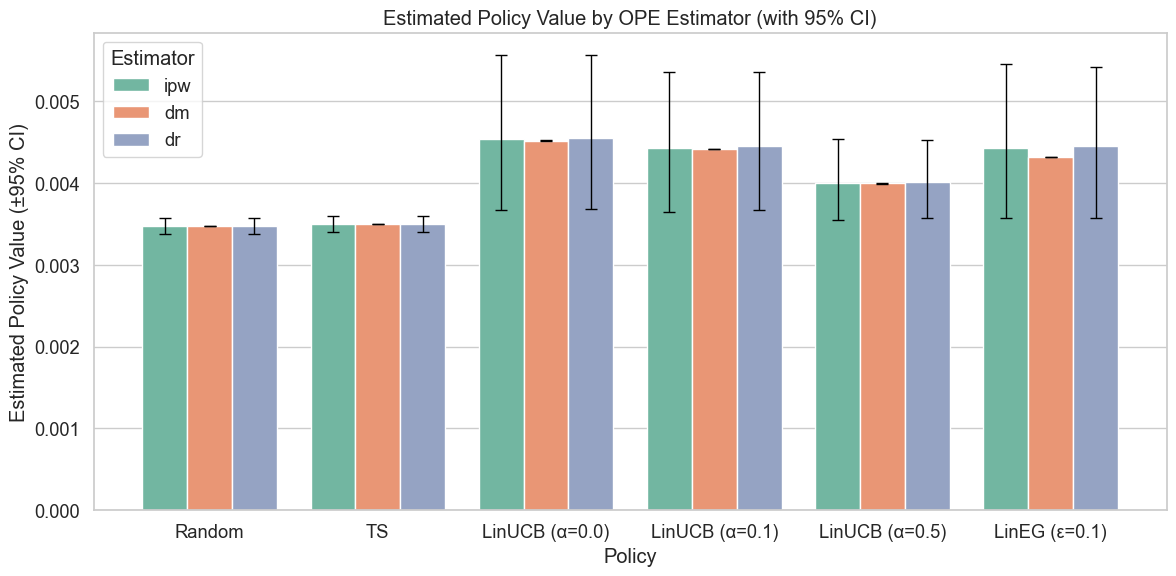

In [ ]:
plt.figure(figsize=(12, 6))

# Main barplot
ax = sns.barplot(
    data=df_results,
    x="Policy",
    y="Estimated Value",
    hue="Estimator",
    palette="Set2",
    ci=None,
    dodge=True,
)

# Extract hue order to match estimator mapping:
hue_order = df_results["Estimator"].unique().tolist()
n_hue = len(hue_order)
bar_width = 0.8 / n_hue  # total bar width split across estimators

# Compute correct x-position and draw error bars manually:
for i, row in df_results.iterrows():
    policy_index = df_results["Policy"].unique().tolist().index(row["Policy"])
    estimator_index = hue_order.index(row["Estimator"])

    # Calculate x-position:
    x = policy_index - 0.4 + bar_width / 2 + estimator_index * bar_width
    y = row["Estimated Value"]
    err_low = y - row["CI Lower"]
    err_up = row["CI Upper"] - y

    # Adding error bar:
    ax.errorbar(
        x=x,
        y=y,
        yerr=[[err_low], [err_up]],
        fmt='none',
        c='black',
        capsize=4,
        lw=1,
    )

# Full plot:
plt.title("Estimated Policy Value by OPE Estimator (with 95% CI)")
plt.xticks(rotation=0, ha="center")
plt.ylabel("Estimated Policy Value (±95% CI)")
plt.tight_layout()
plt.legend(title="Estimator")
plt.show()

In [ ]:
print("Unique actions:", np.unique(bandit_feedback["action"]))
print("n_actions:", bandit_feedback["n_actions"])
print("Context shape:", bandit_feedback["context"].shape)
print("Mean reward:", bandit_feedback["reward"].mean())

Unique actions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
n_actions: 80
Context shape: (1374327, 12)
Mean reward: 0.0034693344451502445
